In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Translation files

In [ ]:
from fastai.text import *

In [ ]:
PATH = 'F:\\Projects\\java\\CodeTokins\\base'
# TMP_PATH = PATH/'tmp'
# TMP_PATH.mkdir(exist_ok=True)
info_path = PATH +'\\info.csv'


In [ ]:
data = []
with open(info_path, encoding='utf-8') as info_file:
    for line in info_file:
        i = line.index(';')
        methodName = line[:i]
        # исключая ";" и перевод строки
        fileName = line[i+1:-1]
        with open(PATH + "\\" + fileName +".csv", encoding='utf-8') as methodBodyFile:
            methodBody = methodBodyFile.readlines()
        bodyTuples = []
        for row in methodBody:
            i = row.index(";")
            bodyTuples.append((row[0:i].lower(),row[i+1:-1].lower()))
        data.append((methodName.lower().split(),bodyTuples))

In [ ]:
data[:2]

In [ ]:
X  = [x for y,x in data]
Y  = [y for y,x in data]

In [ ]:
Y[:2]

In [ ]:
print(np.percentile([len(x) for x in X], 89),np.percentile([len(y) for y in Y], 89))
temp1_forGraph = [int(np.percentile([len(o) for o in X], i)) for i in range(60,101)]
plt.plot(range(60,101),temp1_forGraph)

In [ ]:
keep = np.array([len(x)<300 for x in X])

In [ ]:
keep[:200]

In [ ]:
X  = np.array(X)[keep]
Y  = np.array(Y)[keep]
print(len(X),len(Y))

In [ ]:
freqY = Counter(word for row in Y for word in row)
# print(len(freq))
itosY = [o for o,c in freqY.most_common()]
itosY.insert(0, '_bos_')
itosY.insert(1, '_pad_')
itosY.insert(2, '_eos_')
itosY.insert(3, '_unk')
stoiY = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itosY)})
idsY = np.array([([stoiY[word] for word in row] + [2]) for row in Y])
idsY[:20]

In [ ]:
freqX = Counter(word for row in X for tup in row for word in tup)
print(len(freqX))
print(freqX.most_common()[:5])

itosX = [o for o,c in freqX.most_common(40000)]
itosX.insert(0, '_bos_')
itosX.insert(1, '_pad_')
itosX.insert(2, '_eos_')
itosX.insert(3, '_unk')
print(itosX[:5])
stoiX = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itosX)})
blocks = []
for block in X:
    blockArray = np.zeros((len(block)+1,2),dtype=np.int32)
    for tupIndex in range(len(block)):
        blockArray[tupIndex,0] = stoiX[block[tupIndex][0]]
        blockArray[tupIndex,1] = stoiX[block[tupIndex][1]]
    blockArray[tupIndex+1,0] = 2
    blockArray[tupIndex+1,1] = 2
    blocks.append(blockArray)
idsX = np.array(blocks)
# idsX = np.array([([(stoiX[tup[0]],stoiX[tup[1]]) for tup in block] + [(2,2)]) for block in X])
# pdb.set_trace()
print(idsX[:2])
print(X[:2])
print(len(X[0]),len(X[1]),len(idsX[0]),len(idsX[1]))




In [ ]:
[(itosX[tup[0]],itosX[tup[1]]) for tup in idsX[0]]

## Model data

In [ ]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [ ]:
temp1_forGraph = [int(np.percentile([len(o) for o in idsX], i)) for i in range(85,101)]
plt.plot(range(85,101),temp1_forGraph)
# X_len_90 = int(np.percentile([len(o) for o in idsX], 99))
Y_len_90 = int(np.percentile([len(o) for o in idsY], 99))
print(Y_len_90)

In [ ]:
# idsX_tr = np.array([o[:X_len_90] for o in idsX])
idsY = np.array([o[:Y_len_90] for o in idsY])

In [ ]:
np.random.seed(42)
trn_keep = np.random.rand(len(idsX))>0.1
X_trn,Y_trn = idsX[trn_keep],idsY[trn_keep]
X_val,Y_val = idsX[~trn_keep],idsY[~trn_keep]
len(X_trn),len(X_val)

In [ ]:
trn_ds = Seq2SeqDataset(X_trn,Y_trn)
val_ds = Seq2SeqDataset(X_val,Y_val)

In [ ]:
bs=64

In [119]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X_set = X
        self.Y_set = Y
        self.maxXLen = 0
        self.maxYLen = 0
        for i in range(len(X)):
            lenX = len(self.X_set[i])
            lenY = len(self.Y_set[i])
            if lenX>self.maxXLen:
                self.maxXLen = lenX
            if lenY>self.maxYLen:
                self.maxYLen = lenY
    def __len__(self):
        return len(self.X_set)
    def __getitem__(self, index):        
        x = torch.LongTensor(self.X_set[index])
        x = F.pad(x, (0, 0, 0, self.maxXLen - len(x)), value=1).data
        y = torch.LongTensor(self.Y_set[index])
        y = F.pad(y, (0, self.maxYLen - len(y)), value=1).data
#         print(type(x),type(y))
        return x, y

In [120]:
dataSetTrn = MyDataSet(X_trn,Y_trn)
dataLoaderTrn = torch.utils.data.DataLoader(dataSetTrn,batch_size=64)
dataSetVal = MyDataSet(X_val,Y_val)
dataLoaderVal = torch.utils.data.DataLoader(dataSetVal,batch_size=64)

In [98]:
it = iter(dataLoader)
its = [next(it) for i in range(1)]
[(len(x),len(y)) for x,y in its]

[(64, 64)]

In [102]:
for butch_X,butch_Y in its:
    x = butch_X[0] 
    print(len(butch_X),len(x))
    for tup in x:
        print((itosX[int(tup[0])], itosX[int(tup[1])]))
    y = butch_Y[0] 
    print(len(butch_Y),len(y))
    for o in y:
        print(itosY[o])

64 300
('method_declaration', 'tag')
('modifier', 'public')
('void_type', 'void')
('method_declaration_name', 'tag')
('symbol', '(')
('simple_name', 'coding')
('simple_name', 'method')
('simple_name', 'head')
('simple_name', 'coding')
('symbol', ')')
('block_stmt', '{')
('nextline', 'tag')
('expression_stmt', 'tag')
('this_expr', 'this')
('symbol', '.')
('field_access_expr', 'tag')
('simple_name', 'head')
('simple_name', 'coding')
('assign_expr', '=')
('name_expr', 'tag')
('simple_name', 'head')
('simple_name', 'coding')
('symbol', ';')
('nextline', 'tag')
('block_stmt', '}')
('_eos_', '_eos_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')

In [93]:
class DataGenerator():
    def __init__(self, X, Y, bs = 1):
        self.X_set = X
        self.Y_set = Y
        self.bs = bs
        self.index = 0
    def __len__(self):
        return len(X) // bs
    def __next__(self):
        if self.index + bs >= len(self):
            raise StopIteration
        X_batch =[]
        Y_batch =[]
        maxXLength = 0
        maxYLength = 0
        for i in range(self.bs):
            x = self.X_set[self.index + i]
            y = self.Y_set[self.index + i]
            if len(x)>maxXLength:
                maxXLength = len(x)
            if len(y)>maxYLength:
                maxYLength = len(y)
        for i in range(self.bs):
            x = torch.LongTensor(self.X_set[self.index])
            x = F.pad(x, (0, 0, 0, maxXLength - x.size()[0]), value=1)
            y = torch.LongTensor(self.Y_set[self.index])
            y = F.pad(y, (0, maxYLength - y.size()[0]), value=1)
            X_batch.append(x)
            Y_batch.append(y)
            self.index += 1 
        
#         X_batch = torch.LongTensor(self.X_set[self.index]).unsqueeze(0)
#         Y_batch = torch.LongTensor(self.Y_set[self.index]).unsqueeze(0)
#         self.index += 1 
#         if self.index >= len(self):
#             raise StopIteration
        return torch.stack(X_batch), torch.stack(Y_batch)
    def __iter__(self):
        self.index = 0
        return self

In [94]:
dg = DataGenerator(X_trn,Y_trn,bs=bs)
it = iter(dg)
its = [next(it) for i in range(1)]
[(len(x),len(y)) for x,y in its]

[(64, 64)]

In [95]:
for butch_X,butch_Y in its:
    x = butch_X[0]       
    for tup in x:  
#           print(tup)
        print((itosX[int(tup[0])], itosX[int(tup[1])]))
#     for i in y:
#         print(itosY[i])

('method_declaration', 'tag')
('modifier', 'public')
('void_type', 'void')
('method_declaration_name', 'tag')
('symbol', '(')
('simple_name', 'coding')
('simple_name', 'method')
('simple_name', 'head')
('simple_name', 'coding')
('symbol', ')')
('block_stmt', '{')
('nextline', 'tag')
('expression_stmt', 'tag')
('this_expr', 'this')
('symbol', '.')
('field_access_expr', 'tag')
('simple_name', 'head')
('simple_name', 'coding')
('assign_expr', '=')
('name_expr', 'tag')
('simple_name', 'head')
('simple_name', 'coding')
('symbol', ';')
('nextline', 'tag')
('block_stmt', '}')
('_eos_', '_eos_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad_', '_pad_')
('_pad

In [103]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, enc_vords,  dec_vords, nh,em_enc_len = 300, em_dec_len = 300, out_sl = 5, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = nn.Embedding(enc_vords, em_enc_len, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_enc_len*2, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_dec_len, bias=False)
       
        self.emb_dec = nn.Embedding(dec_vords, em_dec_len, padding_idx=1)
        self.gru_dec = nn.GRU(em_dec_len, em_dec_len, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_dec_len, dec_vords)
#       выяснить зачем
#         self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        inp = inp.cuda()
        tags = inp[:,:,0].t()
        cods = inp[:,:,1].t()
#         pdb.set_trace()        
        
        bs,sl,_ = inp.size()
#         must be SeqLen x ButchSize
#         print("tags size = ", tags.size(), ", is cuda = ",tags.is_cuda)
#         print("cods size = ", cods.size(), ", is cuda = ",cods.is_cuda)
             
        tagsEmb = self.emb_enc(tags)
        codsEmb = self.emb_enc(tags)
        emb = torch.cat((tagsEmb,codsEmb),dim=2)
        emb = self.emb_enc_drop(emb)
#         must be SeqLen x ButchSize x EmbLenth
#         print("emb size = ", emb.size(),", is cuda = ", emb.is_cuda)
    
        h = self.initHidden(bs)
#         print("hiden size = ", h.size(),", is cuda = ", h.is_cuda)    
        
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
#         print("hiden size = ", h.size(), ", is cuda = ",h.is_cuda)        
        dec_inp = Variable(torch.zeros(bs).long().cuda())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = Variable(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return Variable(torch.zeros(self.nl, bs, self.nh).cuda())

In [104]:
rnnModule = Seq2SeqRNN(len(itosX),len(itosY),250).cuda()

In [105]:
dg = DataGenerator(X_trn,Y_trn,bs=64)
it = iter(dg)
its = next(it)
print(len(its[0]))

# fi = its[0][:,0].unsqueeze(0)
print(rnnModule(its[0]))
print(len(Y_trn))

64
Variable containing:
( 0  ,.,.) = 
  3.1941e-02 -1.1317e-01 -9.0981e-02  ...  -2.9636e-02  3.4104e-02  7.5628e-02
  2.4426e-03 -1.0086e-01 -1.1154e-01  ...   2.0760e-02 -1.9135e-02  2.1787e-02
  5.5850e-03 -1.1234e-01 -8.4713e-02  ...  -2.8101e-02  2.8210e-02  6.3224e-02
                 ...                   ⋱                   ...                
 -3.5576e-02 -7.3265e-02 -6.4473e-02  ...  -8.3649e-02  7.6866e-02 -1.2969e-02
  2.9423e-02 -4.8717e-02 -9.1078e-02  ...  -1.0189e-01  5.3860e-02  3.7703e-02
 -2.0399e-02 -4.4840e-02 -5.9805e-02  ...  -1.5844e-02  1.4859e-02 -6.6942e-03

( 1  ,.,.) = 
  6.9700e-02 -1.2476e-01 -7.5250e-02  ...   1.6205e-02  1.3221e-01  3.6766e-02
 -7.4773e-04 -5.7421e-02 -4.5846e-02  ...   2.5695e-02 -1.4295e-02  1.5252e-02
 -7.8600e-03 -2.0580e-01 -1.7935e-01  ...  -1.4778e-01  4.0774e-02  9.1379e-02
                 ...                   ⋱                   ...                
 -3.8922e-02  1.6601e-01 -7.5522e-02  ...  -2.1031e-02  3.1316e-02 -4.8713e-02

In [106]:
def seq2seq_loss(inp, target):
    inp = inp.cuda().contiguous()
    target = target.t().cuda().contiguous()
    sl,bs = target.size()
    sl_in,bs_in,nc = inp.size()
    if sl>sl_in: 
        inp = F.pad(inp, (0,0,0,0,0,sl-sl_in))
    inp = inp[:sl]
    return F.cross_entropy(inp.view(-1,nc), target.view(-1))#, ignore_index=1)

In [64]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [121]:
# trn_dg = DataGenerator(X_trn,Y_trn,bs = 64)
# val_dg = DataGenerator(X_val,Y_val,bs = 64)

md = ModelData(PATH, dataLoaderTrn, dataLoaderVal)

In [110]:
USE_GPU = False

In [122]:
learn = RNN_Learner(md, SingleModel(rnnModule.cuda()), opt_fn=opt_fn)
learn.crit = seq2seq_loss

 70%|██████▉   | 97/139 [00:15<00:06,  6.75it/s, loss=21.3]

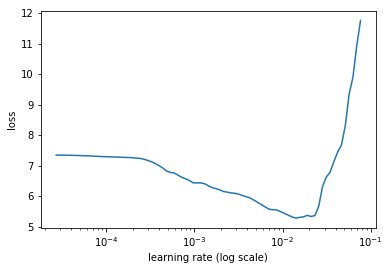

In [112]:
learn.lr_find()
learn.sched.plot()

In [123]:
lr=4e-3

In [124]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      4.606968   6.15207   
    1      4.535179   7.350331                              
    2      4.564148   6.158863                              
    3      4.388061   6.270036                              
    4      4.316981   5.059777                              


[array([5.05978])]

In [125]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      4.542603   7.416899  
    1      4.298169   6.729258                              
    2      4.287731   6.402502                              
    3      4.114046   5.34984                               
    4      3.87193    5.040037                              


[array([5.04004])]

In [126]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      4.31178    6.905747  
    1      4.198225   6.532069                              
    2      3.992814   6.307763                              
    3      3.915764   5.182025                              
    4      3.911686   4.881518                              


[array([4.88152])]

In [139]:
x,y = next(iter(dataLoaderVal))
probs = learn.model(V(x))
print(probs.size())
preds = to_np(probs.max(2)[1])
print(preds.shape)

print(y.size())


for i in range(20):
#     print(' '.join([itosX[o] for o in x[:,i]]))
    print(' '.join([itosY[o] for o in y[i,:]]))
    print(' '.join([itosY[o] for o in preds[:,i]]))
    print()

torch.Size([4, 64, 1543])
(4, 64)
torch.Size([64, 6])
read array from _eos_ _pad_ _pad_
set _eos_ _eos_ _pad_

decode k _eos_ _pad_ _pad_ _pad_
is _eos_ _eos_ _pad_

define _eos_ _pad_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

attribute size _eos_ _pad_ _pad_ _pad_
is _eos_ _eos_ _pad_

visit refs _eos_ _pad_ _pad_ _pad_
set _eos_ _eos_ _pad_

remove attribute _eos_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

canonical instance _eos_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

is empty _eos_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

string for debug _eos_ _pad_ _pad_
get _eos_ _eos_ _pad_

to string _eos_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

parse _eos_ _pad_ _pad_ _pad_ _pad_
check _eos_ _eos_ _pad_

visit refs _eos_ _pad_ _pad_ _pad_
get _eos_ _eos_ _pad_

get cp index _eos_ _pad_ _pad_
get _eos_ _eos_ _pad_

get highest class version _eos_ _pad_
get _eos_ _pad_ _pad_

is reader _eos_ _pad_ _pad_ _pad_
is _eos_ _eos_ _pad_

read data from _eos_ _pad_ _pad_
set _eos_ _eos_ _pad_

compute 